# Parse A7

In [3]:
confidence=0.95

In [4]:
def get_id(line):
    return "_".join(map(str, [line['chromosome_name'], line['start'], line['stop']]))

In [5]:
import pandas as pd
table = pd.read_table("A7.tsv")
table['id']=table.apply(get_id, axis=1)
table = table.set_index('id')
table.columns

Index([u'chromosome_name', u'start', u'stop', u'reference', u'variant',
       u'type', u'gene_name', u'transcript_name', u'transcript_species',
       u'transcript_source', u'transcript_version', u'strand',
       u'transcript_status', u'trv_type', u'c_position', u'amino_acid_change',
       u'ucsc_cons', u'domain', u'all_domains', u'deletion_substructures',
       u'transcript_error', u'brain.rcnt.llr3_ref', u'brain.rcnt.llr3_var',
       u'brain.rcnt.llr3_VAF', u'kidney.rcnt.llr3_ref',
       u'kidney.rcnt.llr3_var', u'kidney.rcnt.llr3_VAF',
       u'liver.rcnt.llr3_ref', u'liver.rcnt.llr3_var', u'liver.rcnt.llr3_VAF',
       u'lung.rcnt.llr3_ref', u'lung.rcnt.llr3_var', u'lung.rcnt.llr3_VAF',
       u'rib.rcnt.llr3_ref', u'rib.rcnt.llr3_var', u'rib.rcnt.llr3_VAF',
       u'tumor.rcnt.llr3_ref', u'tumor.rcnt.llr3_var', u'tumor.rcnt.llr3_VAF',
       u'cluster'],
      dtype='object')

## Write Treeomics input files

In [6]:
ref_cols = ['tumor.rcnt.llr3_ref','brain.rcnt.llr3_ref', 'kidney.rcnt.llr3_ref', 'liver.rcnt.llr3_ref', 'lung.rcnt.llr3_ref', 'rib.rcnt.llr3_ref']
var_cols = ['tumor.rcnt.llr3_var','brain.rcnt.llr3_var', 'kidney.rcnt.llr3_var', 'liver.rcnt.llr3_var', 'lung.rcnt.llr3_var', 'rib.rcnt.llr3_var']

cols = ['breast', 'brain', 'kidney', 'liver', 'lung', 'rib']
table2 = table[['cluster', 'gene_name', 'chromosome_name', 'start'] + ref_cols + var_cols]
table2.columns = ['cluster', 'gene_name', 'chromosome_name', 'start']+['ref-'+c for c in cols] + ['var-'+c for c in cols] 

with open("A7_treeomics_coverage.txt", "w") as f:
    f.write("\t".join(["Chromosome", "Position", "Change", "Gene", "breast_0", "brain_0", "kidney_0", "liver_0", "lung_0", "rib_0"]) + "\n")
    for i, row in table2.iterrows():
        f.write("\t".join(map(str, [row['chromosome_name'], row['start'], 'X>Y', row['gene_name'], 
                                    row['ref-breast'] + row['var-breast'], 
                                    row['ref-brain'] + row['var-breast'], 
                                    row['ref-kidney'] + row['var-kidney'], 
                                    row['ref-liver'] + row['var-liver'], 
                                    row['ref-lung'] + row['var-lung'], 
                                    row['ref-rib'] + row['var-rib']])) + "\n")
    
with open("A7_treeomics_mut.txt", "w") as f:
    f.write("\t".join(["Chromosome", "Position", "Change", "Gene", "breast_0", "brain_0", "kidney_0", "liver_0", "lung_0", "rib_0"]) + "\n")
    for i, row in table2.iterrows():
        f.write("\t".join(map(str, [row['chromosome_name'], row['start'], 'X>Y', row['gene_name'], 
                                    row['var-breast'], row['var-brain'], row['var-kidney'], row['var-liver'], 
                                    row['var-lung'], row['var-rib']])) + "\n")

## Generate MACHINA input file

In [7]:
ref_cols = ['tumor.rcnt.llr3_ref','brain.rcnt.llr3_ref', 'kidney.rcnt.llr3_ref', 'liver.rcnt.llr3_ref', 'lung.rcnt.llr3_ref', 'rib.rcnt.llr3_ref']
var_cols = ['tumor.rcnt.llr3_var','brain.rcnt.llr3_var', 'kidney.rcnt.llr3_var', 'liver.rcnt.llr3_var', 'lung.rcnt.llr3_var', 'rib.rcnt.llr3_var']

cols = ['breast', 'brain', 'kidney', 'liver', 'lung', 'rib']
table = table[['cluster']+ref_cols+var_cols]
table.columns = ['cluster']+['ref-'+c for c in cols] + ['var-'+c for c in cols]

### Reassign clusters of mutations 7_12163423_12163423 and 7_57562948_57562948

In [8]:
ctable = table.groupby('cluster').sum()
ctable.head()
#print table[table['cluster'] == 3].groupby('var-rib').count()

#table[table['cluster'] == 3][table['var-rib'] == 47]['cluster']=2
#table[table['cluster'] == 3][table['var-rib'] == 81]['cluster']=2
print table.loc['7_12163423_12163423']
print table.loc['7_57562948_57562948']

table.loc['7_12163423_12163423']['cluster']=2
table.loc['7_57562948_57562948']['cluster']=2

global corrected_confidence
nsamples = len([c for c in ctable.columns if c.startswith('ref')])
nclusters = len(ctable)
corrected_confidence = 1-((1.-confidence)/(nsamples*nclusters))
print corrected_confidence

assert(corrected_confidence > confidence)
assert(corrected_confidence < 1.0)


cluster         3
ref-breast    161
ref-brain     218
ref-kidney    185
ref-liver     102
ref-lung      132
ref-rib       114
var-breast      0
var-brain       6
var-kidney     60
var-liver     104
var-lung        0
var-rib        47
Name: 7_12163423_12163423, dtype: int64
cluster         3
ref-breast    196
ref-brain     286
ref-kidney    306
ref-liver     132
ref-lung      235
ref-rib       146
var-breast      1
var-brain       4
var-kidney     67
var-liver     121
var-lung        0
var-rib        81
Name: 7_57562948_57562948, dtype: int64
0.999166666667


## Get intervals

In [9]:
import numpy
from scipy.stats import beta
from scipy.stats import norm

def binomial_hpdr(n, N, pct, a=1, b=1, n_pbins=1e3):
    """
    Function computes the posterior mode along with the upper and lower bounds of the
    **Highest Posterior Density Region**.

    Parameters
    ----------
    n: number of successes 
    N: sample size 
    pct: the size of the confidence interval (between 0 and 1)
    a: the alpha hyper-parameter for the Beta distribution used as a prior (Default=1)
    b: the beta hyper-parameter for the Beta distribution used as a prior (Default=1)
    n_pbins: the number of bins to segment the p_range into (Default=1e3)

    Returns
    -------
    A tuple that contains the mode as well as the lower and upper bounds of the interval
    (mode, lower, upper)

    """
    # fixed random variable object for posterior Beta distribution
    rv = beta(n+a, N-n+b)
    # determine the mode and standard deviation of the posterior
    stdev = rv.stats('v')**0.5
    mode = (n+a-1.)/(N+a+b-2.)
    # compute the number of sigma that corresponds to this confidence
    # this is used to set the rough range of possible success probabilities
    n_sigma = numpy.ceil(norm.ppf( (1+pct)/2. ))+1
    # set the min and max values for success probability 
    max_p = mode + n_sigma * stdev
    if max_p > 1:
        max_p = 1.
    min_p = mode - n_sigma * stdev
    if min_p > 1:
        min_p = 1.
    # make the range of success probabilities
    p_range = numpy.linspace(min_p, max_p, n_pbins+1)
    # construct the probability mass function over the given range
    if mode > 0.5:
        sf = rv.sf(p_range)
        pmf = sf[:-1] - sf[1:]
    else:
        cdf = rv.cdf(p_range)
        pmf = cdf[1:] - cdf[:-1]
    # find the upper and lower bounds of the interval 
    sorted_idxs = numpy.argsort( pmf )[::-1]
    cumsum = numpy.cumsum( numpy.sort(pmf)[::-1] )
    j = numpy.argmin( numpy.abs(cumsum - pct) )
    upper = p_range[ (sorted_idxs[:j+1]).max()+1 ]
    lower = p_range[ (sorted_idxs[:j+1]).min() ]    

    return (mode, lower, upper)

In [10]:
#### 
def get_ub(row, sam):
    v=binomial_hpdr(row['var-'+sam], row['var-'+sam]+row['ref-'+sam], corrected_confidence)
    return v[2]
    

def get_lb(row, sam):
    v=binomial_hpdr(row['var-'+sam], row['var-'+sam]+row['ref-'+sam], corrected_confidence)
    mval = v[1]
    #if mval < 0.01: mval = 0
    return mval

def get_mean(row, sam):
    v=binomial_hpdr(row['var-'+sam], row['var-'+sam]+row['ref-'+sam], corrected_confidence)
    mval = v[0]
    return mval

ctable = table.groupby('cluster').sum()
for sam in cols:
    ctable['ub-'+sam]= ctable.apply(get_ub, args=[sam], axis=1)
    ctable['lb-'+sam]= ctable.apply(get_lb, args=[sam], axis=1)
    ctable[sam]= ctable.apply(get_mean, args=[sam], axis=1)

In [11]:
def get_ub(row, sam):
    v=binomial_hpdr(row['var-'+sam], row['var-'+sam]+row['ref-'+sam], corrected_confidence)
    return v[2]
    

def get_lb(row, sam):
    v=binomial_hpdr(row['var-'+sam], row['var-'+sam]+row['ref-'+sam], corrected_confidence)
    mval = v[1]
    if mval < 0.01: mval = 0
    return mval

def get_mean(row, sam):
    v=binomial_hpdr(row['var-'+sam], row['var-'+sam]+row['ref-'+sam], corrected_confidence)
    mval = v[0]
    return mval

ctable_cutoff = table.groupby('cluster').sum()
for sam in cols:
    ctable_cutoff['ub-'+sam]= ctable.apply(get_ub, args=[sam], axis=1)
    ctable_cutoff['lb-'+sam]= ctable.apply(get_lb, args=[sam], axis=1)
    ctable_cutoff[sam]= ctable.apply(get_mean, args=[sam], axis=1)

In [12]:
def get_vaf(row, sam):
    return float(row['var-'+sam])/float(row['var-'+sam]+row['ref-'+sam])

#ctable_cutoff = table.groupby('cluster').mean()
vafs = pd.DataFrame()
for sam in cols:
    vafs[sam] = table.apply(get_vaf, args=[sam], axis=1)
vafs['cluster'] = table['cluster']

In [13]:
rows = ["6 #anatomical sites\n6 #samples\n10 #mutations\n#sample_index\tsample_label\tanatomical_site_index\tanatomical_site_label\tcharacter_index\tcharacter_label\tf_lb\tf_ub\n",]

def print_char(row, sam):
    return "\t".join(map(str,[i, sam, i, sam, row.name-1, str(row.name), max(row['lb-'+sam] * 2, 0), min(1, 2 * row['ub-'+sam])]))+"\n"

for i, sam in enumerate(cols):
    rows += list(ctable_cutoff.apply(print_char, args=[sam], axis=1))

with open("../A7_MACHINA_"+str(confidence)+".tsv", 'w') as f:
    for line in rows:
        f.write(line)

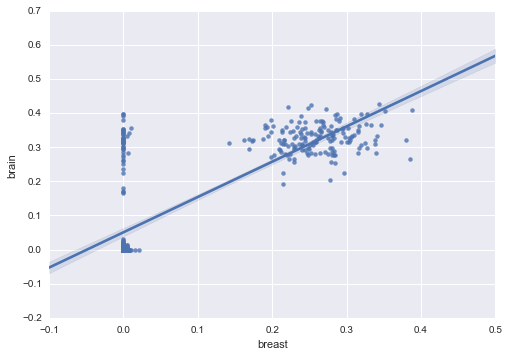

In [19]:
%matplotlib inline

vafs.head()

from matplotlib import pyplot
import seaborn as sns

sns.regplot(x = 'breast', y = 'brain', data = vafs)


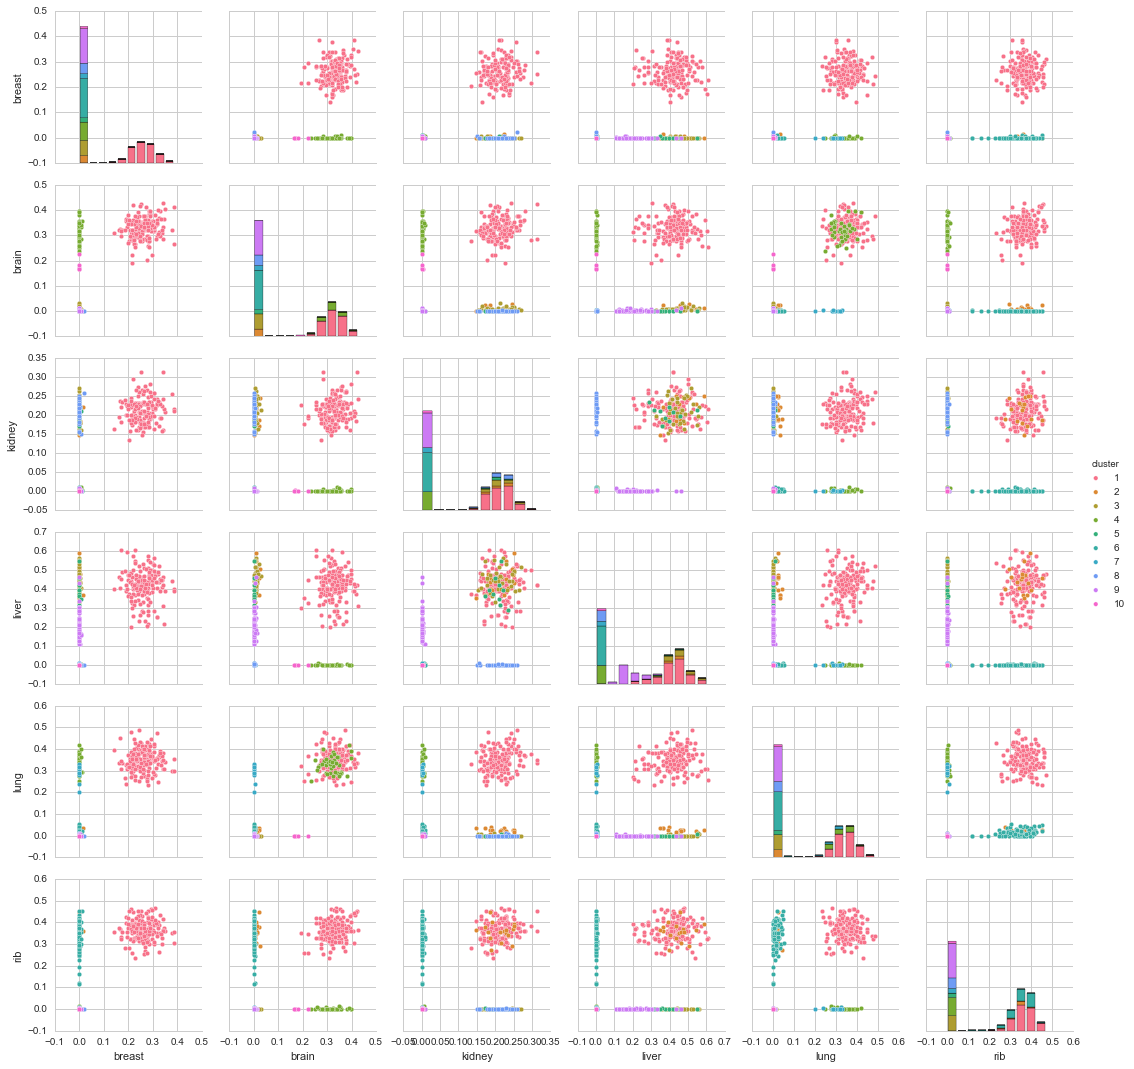

In [20]:
sns.set_style('whitegrid')
sns.pairplot(vafs, hue = 'cluster', vars = ['breast', 'brain', 'kidney', 'liver', 'lung', 'rib'], aspect=1.0, diag_kind = 'hist')

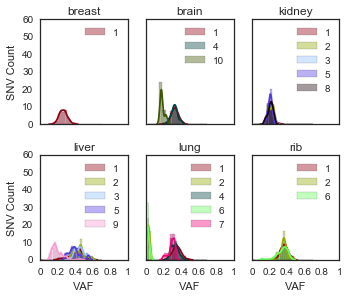

In [21]:
samples = ['breast', 'brain', 'kidney', 'liver', 'lung', 'rib']
sns.set_style('white')
import numpy as np
l = []
for i, sample in enumerate(samples):
    #fig = pyplot.figure()
    pyplot.subplot(2,3,i+1)
    #pypl.set_size_inches((3,3))
    
    for cluster in sorted(vafs['cluster'].unique()):
        data = vafs[vafs['cluster'] == cluster][sample]
        if sum(data)/len(data) < 0.014: continue
        binwidth = 0.025
        #pyplot.hist(data, bins = np.arange(min(data), max(data) + binwidth, binwidth), alpha = 0.4)
        #palette = sns.cubehelix_palette(10, dark = 0.1, light = 0.8, rot = 1, start = 0.5, reverse=True)
        #palette = sns.color_palette('nipy_spectral', 10)
        palette = ["#3e5700",
"#910014",
"#93a900",
"#92c2ff",
"#004141",
"#533ae4",
"#68ff60",
"#f00079",
"#1c0007",
"#ff99d6"]
        a1 = sns.distplot(data, bins = np.arange(0, 0.7+binwidth, binwidth), label = str(cluster), color=palette[(cluster)%10],kde=True, norm_hist=False, kde_kws={'bw':0.015, 'shade_lowest': True})
        if i == 0: l.append(a1)
    pyplot.legend()
            
    if sample in ['breast', 'brain', 'kidney']: 
        pyplot.title(sample)
        pyplot.xlabel('')
        pyplot.xticks([])
        pass
    else:
        pyplot.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['0', '0.2', '0.4', '0.6', '0.8', '1'])
        pyplot.title(sample)
        pyplot.xlabel('VAF')
        
        
    if sample in ['brain', 'kidney', 'lung', 'rib']:
        pyplot.yticks([])
    else:
        pyplot.ylabel("SNV Count")
    #if sample in 
    pyplot.xlim((0,1))
    pyplot.ylim((0, 60))
    #pyplot.legend()
    
#for cluster in sorted(vafs['cluster'].unique()):
#    pyplot.plot([-1,-1], [-1,-1], color = palette[cluster-1], label=cluster)
#handles, labels = pyplot.gca().get_legend_handles_labels()
#pyplot.figlegend(handles, labels, 'upper right', bbox_to_anchor=[1.13, 0.98], title = 'Cluster')
pyplot.gcf().set_size_inches(5, 4.3)
pyplot.tight_layout()


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,  0.22,  0.24,  0.26,
         0.28,  0.3 ]),
 <a list of 1 Patch objects>)

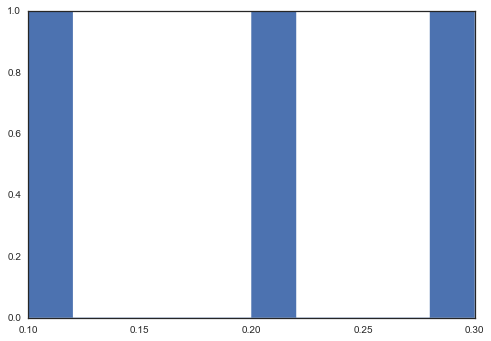

In [22]:
import matplotlib
matplotlib.__version__
pyplot.hist([.1,.2,.3], fill="False", histtype="step")

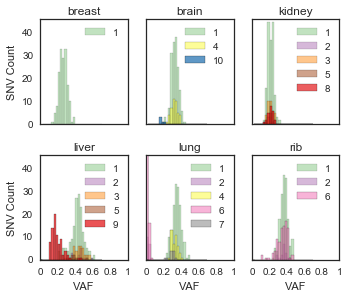

In [23]:
samples = ['breast', 'brain', 'kidney', 'liver', 'lung', 'rib']
sns.set_style('white')
import numpy as np
l = []
for i, sample in enumerate(samples):
    #fig = pyplot.figure()
    pyplot.subplot(2,3,i+1)
    #pypl.set_size_inches((3,3))
    
    for  cluster in sorted(vafs['cluster'].unique()):
        data = vafs[vafs['cluster'] == cluster][sample]
        if sum(data)/len(data) < 0.014: continue
        binwidth = 0.025
        #pyplot.hist(data, bins = np.arange(min(data), max(data) + binwidth, binwidth), alpha = 0.4)
        #palette = sns.cubehelix_palette(10, dark = 0.1, light = 0.8, rot = 1, start = 0.5, reverse=True)
        #palette = sns.color_palette('nipy_spectral', 10)
        palette = sns.color_palette('Set1', 10)

        a1 = sns.distplot(data, bins = np.arange(0, 0.7+binwidth, binwidth), label = str(cluster), color=palette[(cluster+1)%10], hist_kws={'alpha':0.3+0.05*cluster},kde=False, norm_hist=False)
        #a1 = sns.distplot(data, bins = np.arange(0, 0.7+binwidth, binwidth), label = str(cluster), color=palette[(cluster+1)%10], ,kde=False, norm_hist=False)

        if i == 0: l.append(a1)
    pyplot.legend()
            
    if sample in ['breast', 'brain', 'kidney']: 
        pyplot.title(sample)
        pyplot.xlabel('')
        pyplot.xticks([])
        pass
    else:
        pyplot.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['0', '0.2', '0.4', '0.6', '0.8', '1'])
        pyplot.title(sample)
        pyplot.xlabel('VAF')
        
        
    if sample in ['brain', 'kidney', 'lung', 'rib']:
        pyplot.yticks([])
    else:
        pyplot.ylabel("SNV Count")
    #if sample in 
    pyplot.xlim((0,1))
    pyplot.ylim((0, 46))
    #pyplot.legend()
    
#for cluster in sorted(vafs['cluster'].unique()):
#    pyplot.plot([-1,-1], [-1,-1], color = palette[cluster-1], label=cluster)
#handles, labels = pyplot.gca().get_legend_handles_labels()
#pyplot.figlegend(handles, labels, 'upper right', bbox_to_anchor=[1.13, 0.98], title = 'Cluster')
pyplot.gcf().set_size_inches(5, 4.3)
pyplot.tight_layout()

ValueError: tab20 is not a valid palette name

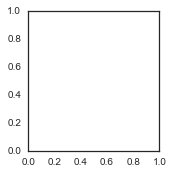

In [24]:
samples = ['breast', 'brain', 'kidney', 'liver', 'lung', 'rib']
sns.set_style('white')
import numpy as np
l = []
for i, sample in enumerate(samples):
    #fig = pyplot.figure()
    pyplot.subplot(2,3,i+1)
    #pypl.set_size_inches((3,3))
    
    clusters = []
    
    for  cluster in sorted(vafs['cluster'].unique()):
        data = vafs[vafs['cluster'] == cluster][sample]
        #if sum(data)/len(data) < 0.014: continue
        clusters.append(cluster)
            
        binwidth = 0.025
        palette = sns.color_palette('tab20', 10)
        #a1 = sns.distplot(data, bins = np.arange(0, 0.7+binwidth, binwidth), label = str(cluster), color=palette[(cluster+1)%10], hist_kws={'alpha':0.3+0.05*cluster},kde=False, norm_hist=False)

        #if i == 0: l.append(a1)
            
    
    sns.swarmplot(data = vafs[vafs['cluster'].isin(clusters)], x = sample, y = 'cluster', orient = 'h', hue = 'cluster', palette = palette, size=4)       
        
    pyplot.gca().legend_.remove()
    xtc = [0,0.1, 0.2,0.3, 0.4, 0.5,0.6, 0.7,0.8,0.9, 1]
    xtl = ['0']+[str(s) for s in xtc[1:-1]]+['1']
    xtnl = ['']*len(xtc)
    #pyplot.legend()       
    if sample in ['breast', 'brain', 'kidney']: 
        pyplot.title(sample)
        pyplot.xlabel('')
        #print pyplot.gca().get_xticks()
        pyplot.xticks(xtc, xtnl)
    #    pass
    else:
        pyplot.xticks(xtc, xtl)
        pyplot.title(sample)
        pyplot.xlabel('')
        
        
    #ytc = [0, 10, 20, 30, 40, 50]
    #ytl = map(str, ytc)
    #ytnl = ['']*len(ytc)
    if sample in ['brain', 'kidney', 'lung', 'rib']:
    #    pyplot.yticks(ytc, ytnl)
        pyplot.ylabel("")
        pass
    else:
        pyplot.ylabel("Cluster")
        #pyplot.yticks(ytc, ytl)
    #if sample in 
    pyplot.xlim((0,0.6))
    #pyplot.ylim((0, 50))
    #pyplot.legend()
    
for cluster in sorted(vafs['cluster'].unique()):
    pyplot.plot([-1,-1], [-1,-1], color = palette[cluster-1], label=cluster)
handles, labels = pyplot.gca().get_legend_handles_labels()

#pyplot.figlegend(handles, labels, 'upper right', bbox_to_anchor=[1.13, 0.98], title = 'Cluster')
pyplot.gcf().set_size_inches(9, 5.6)
pyplot.subplots_adjust(wspace=0.25, hspace=None)
pyplot.savefig('hoadley_vafs.pdf')
#pyplot.tight_layout()

NameError: name 'M' is not defined

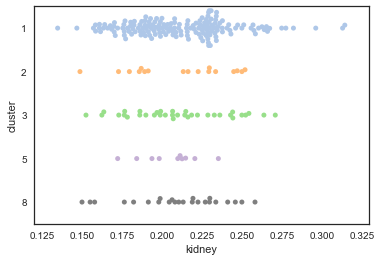

In [104]:
samples = ['breast', 'brain', 'kidney', 'liver', 'lung', 'rib']
sns.set_style('white')
import numpy as np
l = []
for i, sample in enumerate(['kidney']):
    #fig = pyplot.figure()
    #pypl.set_size_inches((3,3))
    
    clusters = []
    
    for  cluster in sorted(vafs['cluster'].unique()):
        data = vafs[vafs['cluster'] == cluster][sample]
        if sum(data)/len(data) < 0.014: continue
        clusters.append(cluster)
            
        binwidth = 0.025
        palette = sns.color_palette('tab20', 10)
        #a1 = sns.distplot(data, bins = np.arange(0, 0.7+binwidth, binwidth), label = str(cluster), color=palette[(cluster+1)%10], hist_kws={'alpha':0.3+0.05*cluster},kde=False, norm_hist=False)

        #if i == 0: l.append(a1)          
    
    palette = sns.color_palette('tab20', 10)
    palette = [p for j,p in enumerate(palette) if j+1 in clusters]
    sns.swarmplot(data = vafs[vafs['cluster'].isin(clusters)], x = sample, y = 'cluster', orient = 'h', hue = 'cluster', palette = palette, size=5)       
        
    pyplot.gca().legend_.remove()
    xtc = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    xtl = ['0.05', '0.1', '0.15', '0.2', '0.25', '0.3']
    xtnl = ['']*len(xtc)
    #pyplot.legend()       
    
    
    for l,k in enumerate(clusters):
        (lb, ub, reported, inferred, jitter) = M[k-1]['kidney']
        print lb, ub

        pyplot.plot([lb,ub], (l ,l) , "|-", linewidth = 2,  markeredgewidth=2, alpha=0.95, c='k', zorder=n - i + 1)
        if lb > 0:
            print inferred
            pyplot.plot([reported, reported], [l-0.4, l+0.4], "b--", zorder=n - i + 2, alpha=0.95, linewidth=2)
        
    pyplot.plot([reported-5, reported-5], [l-0.4, l+0.4], "b--", zorder=n - i + 2, alpha=0.95, linewidth=1, label="Reported")

    #pyplot.plot([0.205953869027, 0.205953869027], [-1,5], "r--", linewidth=1, label="Inferred")
    # pyplot.plot([0.218738399603, 0.218738399603], [-1,5], "r--", linewidth=1, label="Inferred")
  
    import matplotlib.patches as mpatches
    
    rect = mpatches.Rectangle([0.206,-1], .0128, 6, alpha=0.6, color ='darkgrey')
    pyplot.gca().add_patch(rect)
    
    #patches.append(rect)
    #label(grid[1], "Rectangle")
    
    pyplot.title("Kidney")
    pyplot.xticks(xtc, xtc)
    pyplot.xlabel("Frequency")
    pyplot.ylabel("Cluster")
    #pyplot.legend()

    pyplot.xlim((.13,0.3))
    #pyplot.ylim((0, 50))

    

#pyplot.figlegend(handles, labels, 'upper right', bbox_to_anchor=[1.13, 0.98], title = 'Cluster')
pyplot.gcf().set_size_inches(3, 3)
pyplot.tight_layout()
#pyplot.subplots_adjust(wspace=0.25, hspace=None)
pyplot.savefig('kidney_intervals.pdf')


[0.5, 0.4, 0.3, 0, 0.2, -0.1, -0.2, 0.1, -0.3, -0.4]


KeyError: 'kidney'

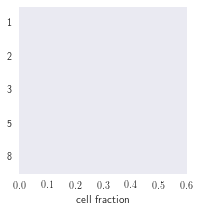

In [26]:
#!/usr/bin/python
import matplotlib
matplotlib.use('ps')
from matplotlib import pyplot 
import seaborn as sns
import numpy as np
import sys
import os
from matplotlib import rc
import random
sns.set_style('dark')

rc('text',usetex=True)
rc('text.latex', preamble='\usepackage{color}')

ordered_samples = ["liver", "kidney", "brain", "rib", "lung", "breast"]
#jit = [0.5, 0.4, 0.3, 0, 0.2, -0.1, -0.2, -0.3, 0.1, -0.4] #+ [.1]*10
jit = [0.5, 0.4, 0.3, 0, 0.2, -0.1, -0.2, 0.1, -0.3, -0.4]

def load(filename):
    M = {}
    with open(filename, "r") as f:
        m = int(f.readline().split()[0])
        n = int(f.readline().split()[0])
        M = [{} for i in range(n)]
        f.readline()
        for line in f:
            s = line.rstrip("\n").split("\t")
            cluster = int(s[2])
            sample = s[1]
            lb = float(s[4])
            ub = float(s[6])
            reported = float(s[5])
            inferred = float(s[7])
            #jitter = float(s[9])
            jitter = jit[cluster]
            M[cluster][sample] = (lb, ub, reported, inferred, jitter)
    return M, m, n

def plot(M, m, n):
    colorMap = { "breast" : "#4DAF4A", "rib" : "#999999", "lung" : "#FF7F00", "liver" : "#377EB8", "brain" : "#F781BF", "kidney" : "#A55628", "adrenal" : "#E41A1C", "spinal" : "#984EA3" }

    pallete = ["#2076b3", "#ff7f0c", "#2ca02b", "#d52728", "#9466bc", "#8b564a", "#f7b6d2", "#7e7f7e", "#bbbd21", "#16bdce"]

    pyplot.figure(figsize=(3,3))
    pyplot.xlim((0, 0.n6))

    labels = ['1','2','3','4','5','6','7','8','9','10']
    print jit
    pyplot.yticks(jit, labels)
    pyplot.xticks(np.arange(0, 0.61, 0.1))
    
    pyplot.ylim((0.05,0.55))
    pyplot.xlabel("cell fraction")
    #pyplot.ylabel("sample")

    #pyplot.plot([0,0], [-1, m+2], "w-", linewidth=1)

    caption = [ None for i in range(n) ]
    for i in range(n):
        caption[i] = str(i+1)
        j=0
        (lb, ub, reported, inferred, jitter) = M[i]['kidney']

        pyplot.plot([lb,ub], [jitter ,jitter], "|-", linewidth = 1,  markeredgewidth=1, alpha=0.95, c='k', zorder=n - i + 1)
        if lb > 0:
            print inferred
            pyplot.plot([reported, reported], [jitter-0.03, jitter+0.03], "b--", zorder=n - i + 2, alpha=0.95, linewidth=1)
        
    pyplot.plot([reported-5, reported-5], [jitter-0.03, jitter+0.03], "b--", zorder=n - i + 2, alpha=0.95, linewidth=1, label="Reported")

    pyplot.plot([0.22, 0.22], [0.05, 0.55], "r--", linewidth=1, label="Inferred")
    #interval = [ None for i in range(n) ]
    interval = [None]*n
    for i in range(n):
        #if i >= 2:
        interval[i] = pyplot.Line2D((0,1),(0,0), color=pallete[i], marker='', linestyle='-')


    for v in jit:
        pyplot.plot([-1,1], [v+0.05,v+0.05], "w-", linewidth=1)



    pyplot.legend()

    pyplot.title("Mutation Clusters in Kidney")
    pyplot.ylabel("Cluster")
    pyplot.tight_layout()
    pyplot.savefig("A7_intervals.pdf")

random.seed(9)
M, m, n = load('./A7_MACHINA_0.95.tsv')
plot(M, m, n)
